In [1]:
import math
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
import pandas as pd
import time

import pickle

In [2]:
class CIFAR10Corrupted(CIFAR10):
    def __init__(self, corrupt_prob, num_classes=10, **kwargs):
        super().__init__(**kwargs)
        if corrupt_prob > 0:
            self.n_classes = num_classes
            self.corrupt_labels(corrupt_prob)

    def corrupt_labels(self, corrupt_prob):
        labels = np.array(self.targets)
        np.random.seed(42)
        mask = np.random.rand(len(labels)) <= corrupt_prob
        rnd_labels = np.random.choice(self.n_classes, mask.sum())
        labels[mask] = rnd_labels
        labels = [int(x) for x in labels]
        self.targets = labels

In [3]:
def get_cifar_dataloaders_corrupted(corrupt_prob=0, batch_size=32):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = CIFAR10Corrupted(root='./CIFAR', train=True, download=True, transform=transform, corrupt_prob=corrupt_prob)
    train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
    testset = CIFAR10Corrupted(root='./CIFAR', train=False, download=True, transform=transform, corrupt_prob=corrupt_prob)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader



In [4]:
class MLP_1_512(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(3*32*32,512)
    self.fc2 = nn.Linear(512,10)
  def forward(self, x):
    x = x.view(-1,3*32*32)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x


In [5]:
def run_train_single_epoch(train_loader, model, device, criterion, optimizer):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*len(inputs)
        if batch_num%200==0:
            print("Batch {} Loss: {}".format(batch_num, loss.item()))
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(train_loader.sampler)
    epoch_acc = num_correct/len(train_loader.sampler)
    return epoch_loss, epoch_acc

def run_validation_single_epoch(valid_loader, model, device, criterion):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(valid_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()*len(inputs)
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(valid_loader.sampler)
    epoch_acc = num_correct/len(valid_loader.sampler)
    return epoch_loss, epoch_acc

def training_loop(model, num_epochs, train_loader, valid_loader, device, \
                  criterion, optimizer, model_name):
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    highest_acc = 1e-10
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = run_train_single_epoch(train_loader, model, device, criterion, optimizer)
        model.eval()
        valid_loss, valid_acc = run_validation_single_epoch(valid_loader, model, device, criterion)
        print("[Epoch {}] Train Loss: {} Vaidation Loss: {} Train Acc: {} Validation Acc: {}".format(\
              epoch, train_loss, valid_loss, train_acc, valid_acc))
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        if valid_acc > highest_acc:
            torch.save(model.state_dict(), "{}.pth".format(model_name))
            highest_acc = valid_acc
    print('Finished Training')
    return train_losses, valid_losses, train_accs, valid_accs

def run_testing(test_loader, model, device):
    model.eval()
    gt_all, preds_all = [], []
    for batch_num, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        gt_all.extend(labels.tolist())
        preds_all.extend(preds.tolist())
    return gt_all, preds_all
    

In [6]:
def plot_losses(training_loss_arr, validation_loss_arr, training_acc_arr, validation_acc_arr, \
                title):
    num_epochs = len(training_loss_arr)
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_loss_arr, '-bo', label="Training Loss")
    ax.plot(range(num_epochs), validation_loss_arr, '-ro', label="Validation Loss")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    plt.subplot(1,2,2)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_acc_arr, '-bo', label="Training Acc")
    ax.plot(range(num_epochs), validation_acc_arr, '-ro', label="Validation Acc")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)    

In [7]:
final_dict = dict()

In [8]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



Extracting ./CIFAR/cifar-10-python.tar.gz to ./CIFAR
Files already downloaded and verified
cuda:0


In [9]:
model = MLP_1_512()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [10]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "MLP_1_512_corr_0")

Batch 0 Loss: 2.310194969177246
Batch 200 Loss: 2.0484631061553955
Batch 400 Loss: 2.087343454360962
Batch 600 Loss: 1.703412413597107
Batch 800 Loss: 1.5354598760604858
Batch 1000 Loss: 1.6426523923873901
Batch 1200 Loss: 1.7381317615509033
Batch 1400 Loss: 1.6048660278320312
[Epoch 0] Train Loss: 1.776464482154846 Vaidation Loss: 1.61041169090271 Train Acc: 0.38034 Validation Acc: 0.4456
Batch 0 Loss: 1.7467830181121826
Batch 200 Loss: 1.6939445734024048
Batch 400 Loss: 1.9093228578567505
Batch 600 Loss: 1.3734657764434814
Batch 800 Loss: 1.3230639696121216
Batch 1000 Loss: 1.5853394269943237
Batch 1200 Loss: 1.6964985132217407
Batch 1400 Loss: 1.3661547899246216
[Epoch 1] Train Loss: 1.5603747912597656 Vaidation Loss: 1.5260864196777344 Train Acc: 0.4571 Validation Acc: 0.4628
Batch 0 Loss: 1.3542492389678955
Batch 200 Loss: 1.3642700910568237
Batch 400 Loss: 1.4998937845230103
Batch 600 Loss: 1.3328484296798706
Batch 800 Loss: 1.5440280437469482
Batch 1000 Loss: 1.3901466131210327


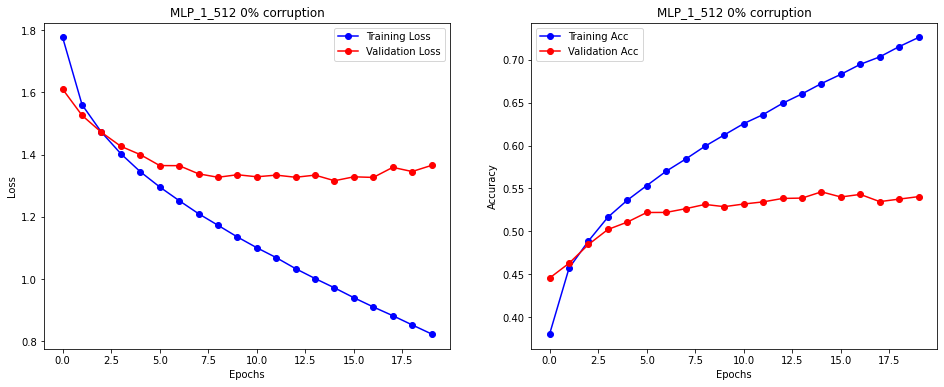

In [11]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "MLP_1_512 0% corruption")

In [12]:
model = MLP_1_512()
sd = torch.load("MLP_1_512_corr_0.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.5461
Confusion Matrix:
 [[626  35  38  21  47  14  23  27 102  67]
 [ 34 634  11  19  17  10  23  19  55 178]
 [ 83  16 349  67 204  95  89  55  15  27]
 [ 30  19  62 316  98 207 133  56  22  57]
 [ 37   7  73  44 569  54  97  77  21  21]
 [ 23   8  49 170 108 458  67  73  20  24]
 [  5  17  53  59 131  49 621  24  18  23]
 [ 33  13  29  48 117  76  17 603   9  55]
 [102  73  18  12  26  24   7  12 650  76]
 [ 32 145   7  21  18  31  25  40  46 635]]


In [14]:
final_dict[0] = {}
final_dict[0]["train_losses"] = train_losses
final_dict[0]["valid_losses"] = valid_losses
final_dict[0]["train_accs"] = train_accs
final_dict[0]["validation_accs"] = validation_accs
final_dict[0]["best_test_acc"] =  accuracy_score(testy, pred)


In [15]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.2)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [16]:
model = MLP_1_512()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [17]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "MLP_1_512_corr_20")

Batch 0 Loss: 2.292755365371704
Batch 200 Loss: 1.9706823825836182
Batch 400 Loss: 2.1190450191497803
Batch 600 Loss: 1.901107907295227
Batch 800 Loss: 1.7039796113967896
Batch 1000 Loss: 1.7483488321304321
Batch 1200 Loss: 1.9195585250854492
Batch 1400 Loss: 1.8967525959014893
[Epoch 0] Train Loss: 1.988942851371765 Vaidation Loss: 1.9019615547180175 Train Acc: 0.31702 Validation Acc: 0.3633
Batch 0 Loss: 1.9161806106567383
Batch 200 Loss: 1.8414024114608765
Batch 400 Loss: 1.894957184791565
Batch 600 Loss: 1.9157861471176147
Batch 800 Loss: 1.7567415237426758
Batch 1000 Loss: 2.1162993907928467
Batch 1200 Loss: 1.778393030166626
Batch 1400 Loss: 2.1346137523651123
[Epoch 1] Train Loss: 1.8636059172821045 Vaidation Loss: 1.8514732917785643 Train Acc: 0.37826 Validation Acc: 0.3824
Batch 0 Loss: 1.9572852849960327
Batch 200 Loss: 1.578989028930664
Batch 400 Loss: 1.6081807613372803
Batch 600 Loss: 1.766908884048462
Batch 800 Loss: 1.5549860000610352
Batch 1000 Loss: 1.8800963163375854


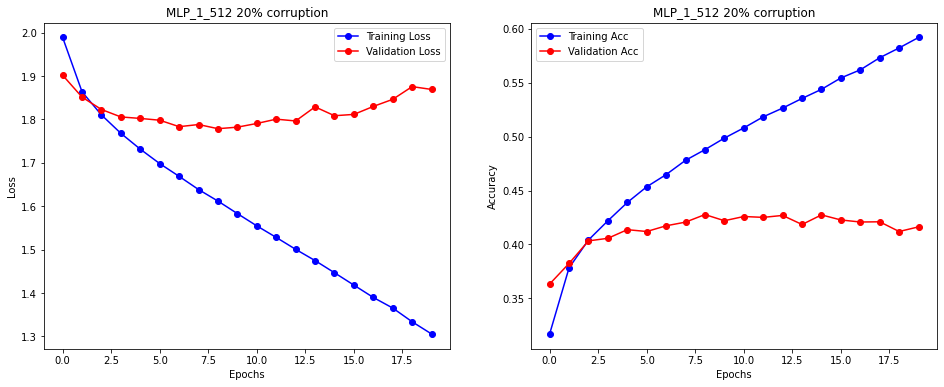

In [18]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "MLP_1_512 20% corruption")

In [19]:
model = MLP_1_512()
sd = torch.load("MLP_1_512_corr_20.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.4277
Confusion Matrix:
 [[479  67  59  25  45  31  53  55 123  59]
 [ 53 572  28  26  25  42  40  42  69 103]
 [ 74  79 251  77 152  94 124  64  38  36]
 [ 51  82  53 259  86 183 132  77  51  59]
 [ 63  56  59  42 403  60 138  81  44  40]
 [ 38  53  66 146  89 344  95  86  29  44]
 [ 30  55  39  60 127  60 538  42  35  32]
 [ 52  62  37  60  94  66  46 465  37  52]
 [124 102  34  32  36  39  26  28 519  57]
 [ 59 233  17  47  34  37  44  48  54 447]]


In [20]:
final_dict[20] = {}
final_dict[20]["train_losses"] = train_losses
final_dict[20]["valid_losses"] = valid_losses
final_dict[20]["train_accs"] = train_accs
final_dict[20]["validation_accs"] = validation_accs
final_dict[20]["best_test_acc"] =  accuracy_score(testy, pred)


In [21]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.4)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [22]:
model = MLP_1_512()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [23]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "MLP_1_512_corr_40")

Batch 0 Loss: 2.326328754425049
Batch 200 Loss: 2.1651298999786377
Batch 400 Loss: 2.1966960430145264
Batch 600 Loss: 1.9558680057525635
Batch 800 Loss: 1.9626394510269165
Batch 1000 Loss: 1.9879438877105713
Batch 1200 Loss: 1.9799163341522217
Batch 1400 Loss: 2.0652823448181152
[Epoch 0] Train Loss: 2.134919815597534 Vaidation Loss: 2.0872999038696287 Train Acc: 0.25378 Validation Acc: 0.2887
Batch 0 Loss: 2.2963600158691406
Batch 200 Loss: 2.2822072505950928
Batch 400 Loss: 2.130051374435425
Batch 600 Loss: 2.1219544410705566
Batch 800 Loss: 1.991573691368103
Batch 1000 Loss: 2.3516294956207275
Batch 1200 Loss: 1.8675812482833862
Batch 1400 Loss: 2.2021427154541016
[Epoch 1] Train Loss: 2.061309487915039 Vaidation Loss: 2.0617430765151976 Train Acc: 0.30088 Validation Acc: 0.3033
Batch 0 Loss: 2.173053741455078
Batch 200 Loss: 2.188823699951172
Batch 400 Loss: 2.0639801025390625
Batch 600 Loss: 2.189192771911621
Batch 800 Loss: 2.224106788635254
Batch 1000 Loss: 2.1037275791168213
Ba

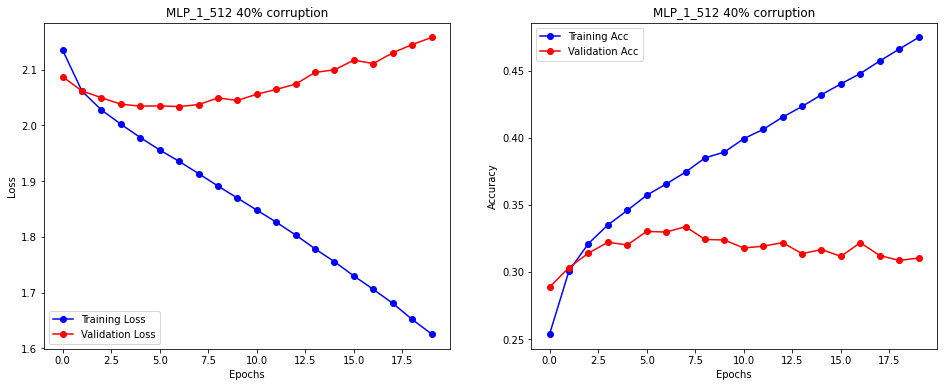

In [24]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "MLP_1_512 40% corruption")

In [25]:
model = MLP_1_512()
sd = torch.load("MLP_1_512_corr_40.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.3337
Confusion Matrix:
 [[357  93  53  68  39  50  87  79 145  49]
 [ 55 447  29  50  34  62  80  56 110  86]
 [ 94  64 180  98  96 111 153 100  65  33]
 [ 70  92  43 239  59 177 140  94  71  48]
 [ 77  68  73  80 228  71 174 116  67  37]
 [ 66  60  48 116  61 304 119 107  61  39]
 [ 38  65  39  93  65  68 480  78  50  36]
 [ 53  65  44  73  58 106  89 368  67  62]
 [ 99 100  20  50  27  39  62  79 458  37]
 [ 60 214  23  55  33  70  87  80 106 276]]


In [26]:
final_dict[40] = {}
final_dict[40]["train_losses"] = train_losses
final_dict[40]["valid_losses"] = valid_losses
final_dict[40]["train_accs"] = train_accs
final_dict[40]["validation_accs"] = validation_accs
final_dict[40]["best_test_acc"] =  accuracy_score(testy, pred)


In [27]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.6)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [28]:
model = MLP_1_512()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [29]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "MLP_1_512_corr_60")

Batch 0 Loss: 2.314392566680908
Batch 200 Loss: 2.2047524452209473
Batch 400 Loss: 2.2667016983032227
Batch 600 Loss: 2.2444517612457275
Batch 800 Loss: 2.2374348640441895
Batch 1000 Loss: 2.146742820739746
Batch 1200 Loss: 2.1963729858398438
Batch 1400 Loss: 2.2658426761627197
[Epoch 0] Train Loss: 2.238088533706665 Vaidation Loss: 2.2189557678222656 Train Acc: 0.19366 Validation Acc: 0.2115
Batch 0 Loss: 2.3923261165618896
Batch 200 Loss: 2.336054801940918
Batch 400 Loss: 2.1202313899993896
Batch 600 Loss: 2.03364896774292
Batch 800 Loss: 2.309628486633301
Batch 1000 Loss: 2.1585633754730225
Batch 1200 Loss: 2.1695854663848877
Batch 1400 Loss: 2.112171173095703
[Epoch 1] Train Loss: 2.19916579536438 Vaidation Loss: 2.2056735630035402 Train Acc: 0.2273 Validation Acc: 0.2257
Batch 0 Loss: 2.2585411071777344
Batch 200 Loss: 2.246022939682007
Batch 400 Loss: 2.2628889083862305
Batch 600 Loss: 2.1227447986602783
Batch 800 Loss: 2.391092300415039
Batch 1000 Loss: 2.1749839782714844
Batch 

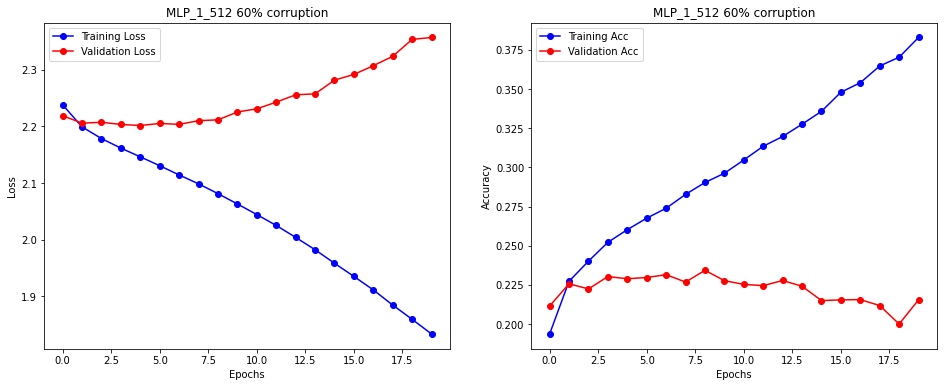

In [30]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "MLP_1_512 60% corruption")

In [31]:
model = MLP_1_512()
sd = torch.load("MLP_1_512_corr_60.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.2343
Confusion Matrix:
 [[245  71  99  49  80  78  53 114 142  96]
 [ 64 247  81  55  88  87  51  99 107 147]
 [ 87  63 204  58 107  92  58 112  98 107]
 [ 60  61 104 112  99 184  81 112  90 118]
 [ 69  57 131  41 221  90  65 124  98  83]
 [ 56  68 100  80  93 216  54 118  99  90]
 [ 70  55 131  60 121  97 200  92  96  90]
 [ 70  71 110  56  93  96  50 284  82  97]
 [ 86  81  72  44  60  73  44  84 326 110]
 [ 60 105  77  47  70  68  58  96 117 288]]


In [32]:
final_dict[60] = {}
final_dict[60]["train_losses"] = train_losses
final_dict[60]["valid_losses"] = valid_losses
final_dict[60]["train_accs"] = train_accs
final_dict[60]["validation_accs"] = validation_accs
final_dict[60]["best_test_acc"] = accuracy_score(testy, pred)


In [33]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.8)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [34]:
model = MLP_1_512()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [35]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "MLP_1_512_corr_80")

Batch 0 Loss: 2.318265914916992
Batch 200 Loss: 2.318925142288208
Batch 400 Loss: 2.2261343002319336
Batch 600 Loss: 2.3271148204803467
Batch 800 Loss: 2.2293028831481934
Batch 1000 Loss: 2.243133783340454
Batch 1200 Loss: 2.289707660675049
Batch 1400 Loss: 2.325493335723877
[Epoch 0] Train Loss: 2.291334224624634 Vaidation Loss: 2.2830935440063476 Train Acc: 0.13908 Validation Acc: 0.1502
Batch 0 Loss: 2.2593283653259277
Batch 200 Loss: 2.246443033218384
Batch 400 Loss: 2.26232647895813
Batch 600 Loss: 2.284428596496582
Batch 800 Loss: 2.262824773788452
Batch 1000 Loss: 2.1834301948547363
Batch 1200 Loss: 2.2058792114257812
Batch 1400 Loss: 2.2847859859466553
[Epoch 1] Train Loss: 2.2725450961303713 Vaidation Loss: 2.2828800186157228 Train Acc: 0.1598 Validation Acc: 0.1528
Batch 0 Loss: 2.201554298400879
Batch 200 Loss: 2.3241705894470215
Batch 400 Loss: 2.248225212097168
Batch 600 Loss: 2.2458901405334473
Batch 800 Loss: 2.3041398525238037
Batch 1000 Loss: 2.157615900039673
Batch 12

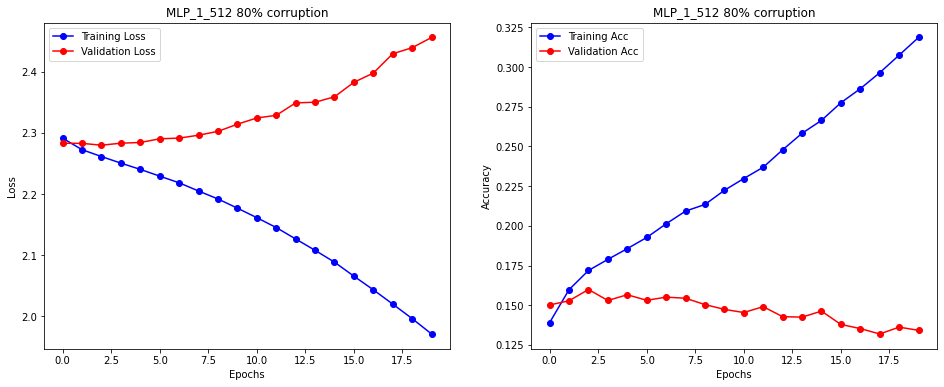

In [36]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "MLP_1_512 80% corruption")

In [37]:
model = MLP_1_512()
sd = torch.load("MLP_1_512_corr_80.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.1599
Confusion Matrix:
 [[171  68  45 114 104  74 103  57 142 133]
 [ 91 143  52 106  79  70 109  78  95 206]
 [107  71  71 135 100  74 126  86 100 117]
 [ 86  70  67 197  99  87 113  59  91 151]
 [102  63  63 123 152  69 121  53  98 110]
 [ 85  81  75 160  95  94  95  88  88 120]
 [ 85  75  62 132  92  57 212  69  99 132]
 [ 89  78  54 123 115  61 115 130 106 127]
 [ 91  90  44  99  90  73 108  56 195 141]
 [ 95 110  51 116  80  57  88  74 113 234]]


In [38]:
final_dict[80] = {}
final_dict[80]["train_losses"] = train_losses
final_dict[80]["valid_losses"] = valid_losses
final_dict[80]["train_accs"] = train_accs
final_dict[80]["validation_accs"] = validation_accs
final_dict[80]["best_test_acc"] = accuracy_score(testy, pred)


In [39]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(1.0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [40]:
model = MLP_1_512()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [41]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 20, train_loader, test_loader,
                                          device, criterion, optimizer, "MLP_1_512_corr_100")

Batch 0 Loss: 2.3176627159118652
Batch 200 Loss: 2.3083884716033936
Batch 400 Loss: 2.316279411315918
Batch 600 Loss: 2.299224615097046
Batch 800 Loss: 2.3058907985687256
Batch 1000 Loss: 2.3383092880249023
Batch 1200 Loss: 2.324772834777832
Batch 1400 Loss: 2.286269426345825
[Epoch 0] Train Loss: 2.3091133625030515 Vaidation Loss: 2.3094862442016604 Train Acc: 0.09982 Validation Acc: 0.0943
Batch 0 Loss: 2.30082631111145
Batch 200 Loss: 2.286478042602539
Batch 400 Loss: 2.325347900390625
Batch 600 Loss: 2.313749074935913
Batch 800 Loss: 2.28525972366333
Batch 1000 Loss: 2.246175527572632
Batch 1200 Loss: 2.2960610389709473
Batch 1400 Loss: 2.298027753829956
[Epoch 1] Train Loss: 2.2970809868621824 Vaidation Loss: 2.3102303913116455 Train Acc: 0.12078 Validation Acc: 0.0973
Batch 0 Loss: 2.2994260787963867
Batch 200 Loss: 2.2316019535064697
Batch 400 Loss: 2.316598892211914
Batch 600 Loss: 2.2545905113220215
Batch 800 Loss: 2.2484090328216553
Batch 1000 Loss: 2.2702367305755615
Batch 1

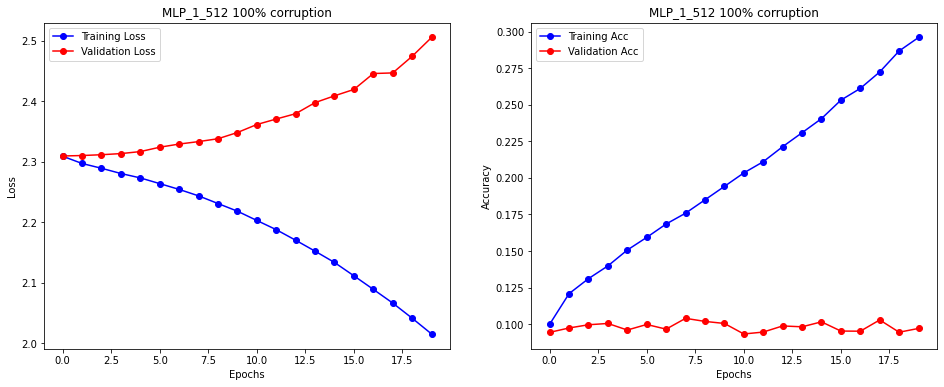

In [42]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "MLP_1_512 100% corruption")

In [43]:
model = MLP_1_512()
sd = torch.load("MLP_1_512_corr_100.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.1039
Confusion Matrix:
 [[134  94  91  45  50  52 150  51 145 202]
 [132 107  87  54  63  78 171  52 134 162]
 [110  86  81  52  55  66 157  43 134 207]
 [128  95  82  49  51  77 142  56 129 203]
 [128  90  75  36  62  66 139  51 125 173]
 [129  91  80  39  66  87 154  52 141 178]
 [110  95  97  51  51  60 176  57 131 169]
 [138  83  98  51  44  70 146  51 128 184]
 [124  81  87  43  65  72 161  57 125 158]
 [131  80  81  51  44  87 179  53 145 167]]


In [44]:
final_dict[100] = {}
final_dict[100]["train_losses"] = train_losses
final_dict[100]["valid_losses"] = valid_losses
final_dict[100]["train_accs"] = train_accs
final_dict[100]["validation_accs"] = validation_accs
final_dict[100]["best_test_acc"] = accuracy_score(testy, pred)


In [45]:
with open('final.pickle', 'wb') as f:
    pickle.dump(final_dict, f, protocol=pickle.HIGHEST_PROTOCOL)


In [46]:
!curl bashupload.com -T final.pickle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Uploaded 1 file, 4 794 bytes

wget http://bashupload.com/7EDJ3/final.pickle


100  4926    0   132  100  4794    464  16880 --:--:-- --:--:-- --:--:-- 17345


In [47]:
!zip mlp.zip *.*
!curl bashupload.com -T mlp.zip

  adding: final.pickle (deflated 21%)
  adding: MLP_1_512_corr_0.pth (deflated 8%)
  adding: MLP_1_512_corr_100.pth (deflated 8%)
  adding: MLP_1_512_corr_20.pth (deflated 8%)
  adding: MLP_1_512_corr_40.pth (deflated 8%)
  adding: MLP_1_512_corr_60.pth (deflated 8%)
  adding: MLP_1_512_corr_80.pth (deflated 8%)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 78 33.3M    0     0   78 26.1M      0  15.4M  0:00:02  0:00:01  0:00:01 15.4M

Uploaded 1 file, 34 926 513 bytes

wget http://bashupload.com/l4j_7/mlp.zip


100 33.3M    0   132  100 33.3M     49  12.5M  0:00:02  0:00:02 --:--:-- 12.5M
